In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from datasets import load_dataset
from tokenizers import ByteLevelBPETokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm.auto import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback
import time
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Function to process and extract specific columns from a dataset
def process_dataset(dataset_name, subset_name, columns): 
    dataset = load_dataset( "McAuley-Lab/Amazon-Reviews-2023", 
                           subset_name, split="full", 
                           trust_remote_code=True ) 
    return dataset.to_pandas()[columns]

# Define the columns to keep
columns_to_keep = ["text", "rating"]

# Process datasets
beauty_df = process_dataset("Amazon-Reviews-2023", "raw_review_Beauty_and_Personal_Care", columns_to_keep)
movies_df = process_dataset("Amazon-Reviews-2023", "raw_review_Movies_and_TV", columns_to_keep)

# Concatenate DataFrames
combined_df = pd.concat([beauty_df, movies_df])

# Remove rows with missing (NaN) values
cleaned_df = combined_df.dropna()

# Create a binary label for sentiment (rating >= 3 as positive)
cleaned_df["sentiment"] = (cleaned_df["rating"] >= 3).astype(int)

# Shuffle the dataset
shuffled_df = cleaned_df.sample(frac=1, random_state=42)

# Separate the two classes
class_0_df = shuffled_df[shuffled_df["sentiment"] == 0]
class_1_df = shuffled_df[shuffled_df["sentiment"] == 1]

# Select 5 million reviews from each class to create a balanced dataset
class_0_sample = class_0_df.head(5_000_000)
class_1_sample = class_1_df.head(5_000_000)

# Combine the samples to create the final balanced dataset
balanced_df = pd.concat([class_0_sample, class_1_sample])

# Shuffle the final balanced dataset
df = balanced_df.sample(frac=1, random_state=42)


In [ ]:
df["sentiment"] = (df["rating"] >= 3).astype(int)

In [4]:
df = pd.read_csv('./Dataset/reviews.csv', escapechar='\t')

In [ ]:
df = df.drop(columns=['rating'])
df.head(10)

,text,sentiment
0,Very disappointed in this product. Perhaps my...,0
1,"I have sensitive skin, and this face wash is g...",1
2,The first mirror failed in under a year. Stil...,1
3,Horrible product comes off in a day- goes on n...,0
4,"great product, fast shipping! a little goes a ...",1
5,We love this movie. My whole family. Our son h...,1
6,would watch again.,1
7,This movie is so heartwarming and fun. The cha...,1
8,All I can say is excellent actors with great s...,1
9,I did not like the stories because they were a...,0


In [2]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12

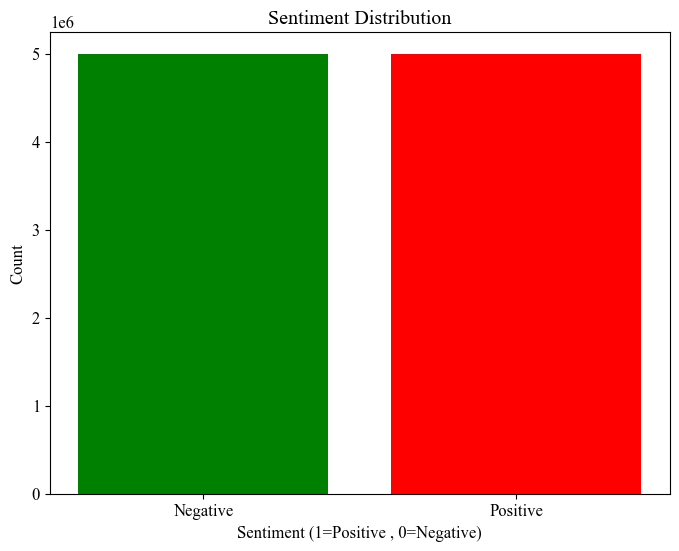

In [3]:
df = pd.read_csv('./Dataset/reviews.csv', escapechar='\t')


# Plot sentiment distribution
plt.figure(figsize=(8, 6))
sentiment_counts = df['sentiment'].value_counts()
plt.bar(sentiment_counts.index, sentiment_counts.values, color=["green","red"])
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment (1=Positive , 0=Negative)")
plt.ylabel("Count")
plt.xticks([1, 0], ["Positive","Negative"], rotation=0)
plt.show()

In [ ]:
df['text'] = df['text'].astype(str).fillna('')

# Initialize BPE tokenizer
tokenizer = ByteLevelBPETokenizer()
tokenizer.train_from_iterator(df["text"].tolist(), vocab_size=30000, min_frequency=2, special_tokens=[
    "<s>",
    "<pad>",
    "</s>",
    "<unk>",
    "<mask>",
])

# Add padding token to the tokenizer
tokenizer.add_special_tokens(["<pad>"])
pad_token_id = tokenizer.token_to_id("<pad>")



# Calculate max length
max_length = 170


# Function to tokenize texts
def tokenize_texts(texts, tokenizer, max_length):
    encoded_texts = [
        tokenizer.encode(text).ids for text in texts
    ]
    padded_texts = pad_sequences(encoded_texts, maxlen=max_length, padding="post", value=pad_token_id, truncating="post")
    return padded_texts

# Tokenize and pad texts
X_encoded = tokenize_texts(df["text"].tolist(), tokenizer, max_length)
y = df["sentiment"].values

# Train-test-validation split
X_train, X_temp, y_train, y_temp = train_test_split( X_encoded, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split( X_temp, y_temp, test_size=0.5, random_state=42 )

# Convert to NumPy arrays for training
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

print(f"Training data shape (X_train, y_train): {X_train.shape}, {y_train.shape}")
print(f"Validation data shape (X_val, y_val): {X_val.shape}, {y_val.shape}")
print(f"Testing data shape (X_test, y_test): {X_test.shape}, {y_test.shape}")

# Save the dataset for further training
np.savez_compressed("/kaggle/working/data.npz",
                    X_train=X_train,
                    y_train=y_train,
                    X_val=X_val,
                    y_val=y_val,
                    X_test=X_test,
                    y_test=y_test)
print("Datasets saved successfully!")

In [ ]:
tokenizer.save_model('./tokenizer')
print("Tokenizer saved successfully!")

In [ ]:
voc_size = 30000
embedding_dim = 64
max_length = X_train.shape[1]
# Build the model

model = Sequential([
    Embedding(input_dim=voc_size, output_dim=embedding_dim, input_length=max_length),
    Bidirectional(GRU(64, return_sequences=True)),
    Bidirectional(GRU(64)),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dense(1, activation="sigmoid")
])
# Compile the model
model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
)
# Build the model with random input data to ensure all layers are initialized
model.build(input_shape=(None, max_length))
model.summary()
# Early stopping to prevent overfitting
early_stopping = EarlyStopping( monitor="val_loss", patience=3, restore_best_weights=True, verbose=1 )
# Train the model with tqdm progress bar
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=1024,  # Batch size 
    callbacks=[early_stopping, TqdmCallback(verbose=1)] # Adds the progress bar ]
)

In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 170, 64)        │     1,920,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 170, 128)       │        49,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,069,251 (7.89 MB)

 Trainable params: 2,069,249 (7.89 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [ ]:

# Save the entire model to a HDF5 file
model.save("./sentiment_analysis_model.h5")
print("Model saved successfully!")

In [ ]:
import json
# Convert the history.history dict to a JSON file
with open('./sentiment_analysis_history.json', 'w') as f:
    json.dump(history.history, f)
print("Training history saved successfully as JSON!")

In [7]:
import json
# Load the saved model
model = tf.keras.models.load_model("./sentiment_analysis_model.h5")
with open('./sentiment_analysis_history.json', 'r') as f:
    history = json.load(f)



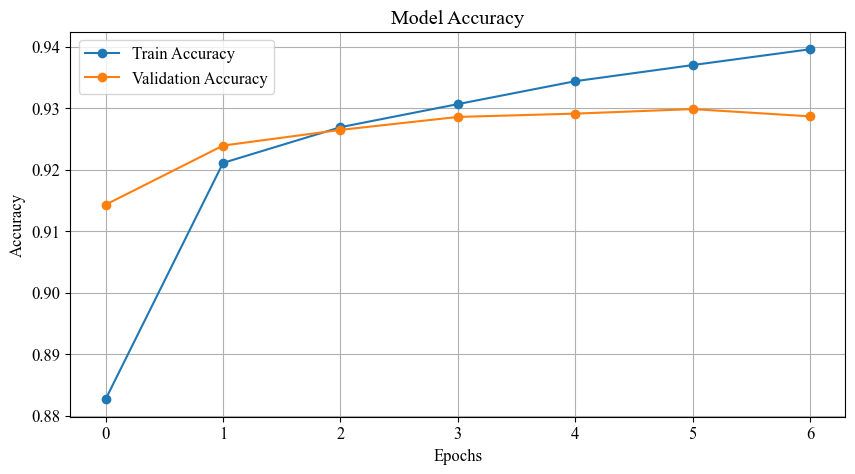

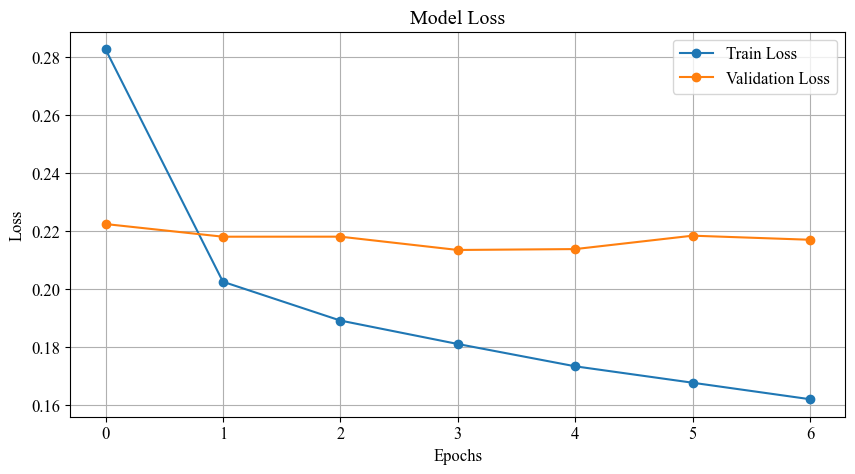

In [8]:
# Plot training accuracy and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history["accuracy"], label="Train Accuracy", marker="o")
plt.plot(history["val_accuracy"], label="Validation Accuracy", marker="o")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.savefig('./Images/accuracy.png',dpi=300,bbox_inches='tight')
plt.show()

# Plot training loss and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history["loss"], label="Train Loss", marker="o")
plt.plot(history["val_loss"], label="Validation Loss", marker="o")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.savefig('./Images/loss.png',dpi=300,bbox_inches='tight')
plt.show()

In [9]:
data = np.load("./Dataset/data.npz")
X_test = data["X_test"]
y_test = data["y_test"]

In [20]:
start_time = time.time()
y_pred = model.predict(X_test[:1000])
y_pred_binary = (y_pred > 0.5).astype(int)
end_time = time.time()
inference_time = end_time - start_time
print(f"Inference time: {(inference_time/1000) :.4f} seconds")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Inference time: 0.0009 seconds


In [5]:
test_loss, test_acc = model.evaluate(
    X_test, y_test,
    verbose=0
)

print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

Test Accuracy: 0.9279, Test Loss: 0.2147


In [10]:
# Predict probabilities and convert to binary predictions
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

report = classification_report(y_test, y_pred_binary, output_dict=True)

print(report)
with open('classification_report.json', 'w') as f:
    json.dump(report, f, indent=4)
print("Classification report saved successfully as JSON!")

46875/46875 ━━━━━━━━━━━━━━━━━━━━ 1207s 26ms/step
{'0': {'precision': 0.9105427877488742, 'recall': 0.9491461474980368, 'f1-score': 0.9294438040082458, 'support': 750071.0}, '1': {'precision': 0.9468841949009161, 'recall': 0.9067325040103796, 'f1-score': 0.926373481156739, 'support': 749929.0}, 'accuracy': 0.9279413333333333, 'macro avg': {'precision': 0.9287134913248951, 'recall': 0.9279393257542082, 'f1-score': 0.9279086425824924, 'support': 1500000.0}, 'weighted avg': {'precision': 0.9287117711649566, 'recall': 0.9279413333333333, 'f1-score': 0.9279087879111074, 'support': 1500000.0}}
Classification report saved successfully as JSON!


AUC-ROC Score: 0.9774
AUC-ROC Score saved successfully!


<Figure size 800x800 with 0 Axes>

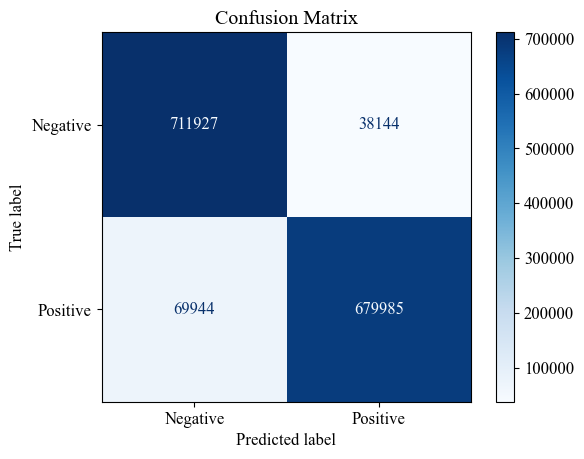

In [13]:
# AUC-ROC score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"AUC-ROC Score: {roc_auc:.4f}")

# Save the AUC-ROC score to a text file
with open('auc_roc_score.txt', 'w') as f:
    f.write(f"AUC-ROC Score: {roc_auc:.4f}\n")
print("AUC-ROC Score saved successfully!")


# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

# Plot confusion matrix
plt.figure(figsize=(8, 8))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.savefig('./Images/confusion_matrix.png',dpi=300,bbox_inches='tight')
plt.show()


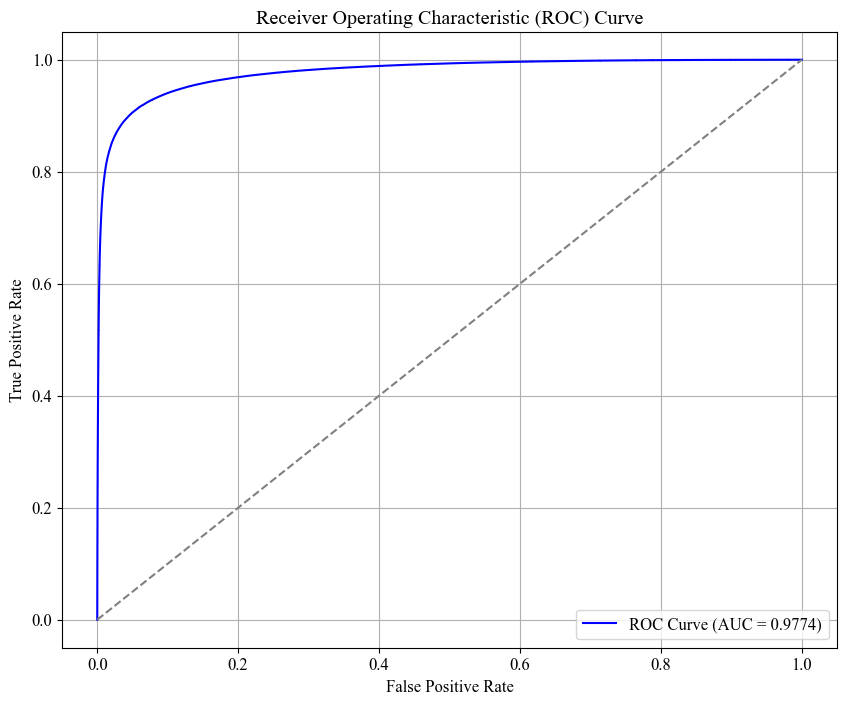

In [14]:
from sklearn.metrics import roc_curve

# Compute False Positive Rate (FPR), True Positive Rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred)


# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()

# Save the plot
plt.savefig('./Images/roc_curve.png',dpi=300,bbox_inches='tight')
plt.show()


In [23]:
# Capture the model summary
model_summary = []
model.summary(print_fn=lambda x: model_summary.append(x))
model_summary = "\n".join(model_summary)

# Save the model summary to a text file with 'utf-8' encoding
with open('model_summary.txt', 'w', encoding='utf-8') as f:
    f.write(model_summary)
print("Model summary saved successfully!")



Model summary saved successfully!
